# Transfer learning for Multiple classes and Multiple labels

In this example, transfer learning is used by training the model from scratch without freezing any layers. The first step is reading images from HDFS and then convert all images into SQL spark dataframe. 
You can refer to the convert images notebook which reads all images from HDFS and convert them into SQL spark dataframe. 
The code also assigned with labels for each image by reading CSV file that contains image indexes and their labels.

## Vistualize the statistical Information about dataset 

The dataset statistical information can be visualized in our dataset statistical data code. 

## Import the required packages
In this following cell all required packages are downloaded. If you get any error please try to install the required packages using pip command or download the required libraries such as BigDL.

In [1]:
import random
import time
from math import ceil
from bigdl.optim.optimizer import SGD, SequentialSchedule, Warmup, Poly, Plateau, EveryEpoch, TrainSummary,\
    ValidationSummary, SeveralIteration, Step, L2Regularizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.storagelevel import StorageLevel
from zoo.common.nncontext import *
from zoo.feature.image.imagePreprocessing import *
from zoo.feature.common import ChainedPreprocessing
from zoo.pipeline.api.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, Dropout
from zoo.pipeline.api.keras.metrics import AUC
from zoo.pipeline.api.keras.optimizers import Adam
from zoo.pipeline.api.keras.models import Model
from zoo.pipeline.api.net import Net
from zoo.pipeline.nnframes import NNEstimator
from zoo.pipeline.api.keras.objectives import BinaryCrossEntropy

/usr/lib64/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools


## Inception pre-trained model 
After downloading the pre-trained models and moving them to HDFS, now you can use any of them with the below defined functions as shown in the following cells.

In [2]:
def get_inception_model(model_path, label_length):
    full_model = Net.load_bigdl(model_path)
    model = full_model.new_graph(["pool5/drop_7x7_s1"])  # this inception
    inputNode = Input(name="input", shape=(3, 224, 224))
    inception = model.to_keras()(inputNode)
    flatten = GlobalAveragePooling2D(dim_ordering='th')(inception)
    dropout = Dropout(0.25)(flatten)
    logits = Dense(label_length, W_regularizer=L2Regularizer(1e-1), b_regularizer=L2Regularizer(1e-1), activation="sigmoid")(dropout)
    lrModel = Model(inputNode, logits)
    return lrModel

In [3]:
def get_resnet_model(model_path, label_length):
    full_model = Net.load_bigdl(model_path)
    model = full_model.new_graph(["pool5"])
    print(('num of model layers: ', len(model.layers)))
    inputNode = Input(name="input", shape=(3, 224, 224))
    resnet = model.to_keras()(inputNode)
    flatten = GlobalAveragePooling2D(dim_ordering='th')(resnet)
    dropout = Dropout(0.2)(flatten)
    logits = Dense(label_length, W_regularizer=L2Regularizer(1e-1), b_regularizer=L2Regularizer(1e-1), activation="sigmoid")(dropout)
    lrModel = Model(inputNode, logits)
    return lrModel

In [4]:
def get_vgg_model(model_path, label_length):
    full_model = Net.load_bigdl(model_path)
    model = full_model.new_graph(["pool5"])
    print(('num of model layers: ', len(model.layers)))
    inputNode = Input(name="input", shape=(3, 224, 224))
    vgg_16 = model.to_keras()(inputNode)
    flatten = GlobalAveragePooling2D(dim_ordering='th')(vgg_16)
    dropout = Dropout(0.25)(flatten)
    logits = Dense(label_length, W_regularizer=L2Regularizer(1e-1), b_regularizer=L2Regularizer(1e-1), activation="sigmoid")(dropout)
    lrModel = Model(inputNode, logits)
    return lrModel

In [5]:
def get_densenet_model(model_path, label_length):
    full_model = Net.load_bigdl(model_path)
    model = full_model.new_graph(["pool5"])
    print(('num of model layers: ', len(model.layers)))
    inputNode = Input(name="input", shape=(3, 224, 224))
    densenet = model.to_keras()(inputNode)
    flatten = GlobalAveragePooling2D(dim_ordering='th')(densenet)
    dropout = Dropout(0.25)(flatten)
    logits = Dense(label_length, W_regularizer=L2Regularizer(1e-1), b_regularizer=L2Regularizer(1e-1), activation="sigmoid")(dropout)
    lrModel = Model(inputNode, logits)
    return lrModel

## Learning Rate Scheduler for SGD optimizer  


In [6]:
def get_sgd_optimMethod(num_epoch, trainingCount, batchSize):
    iterationPerEpoch = int(ceil(float(trainingCount) / batchSize))
    # maxIteration = num_epoch * iterationPerEpoch
    warmupEpoch = 10
    warmup_iteration = warmupEpoch * iterationPerEpoch
    init_lr = 1e-6
    # maxlr = 0.001 * batch_size / 8
    maxlr = 0.001
    print("peak lr is: ", maxlr)
    warmupDelta = (maxlr - init_lr) / warmup_iteration
    cooldownIteration = (num_epoch - warmupEpoch) * iterationPerEpoch

    lrSchedule = SequentialSchedule(iterationPerEpoch)
    lrSchedule.add(Warmup(warmupDelta), warmup_iteration)
    #lrSchedule.add(Step(iterationPerEpoch * 10, 0.1), cooldownIteration)
    lrSchedule.add(Plateau("Loss", factor=0.1, patience=1, mode="min", epsilon=0.01, cooldown=0, min_lr=1e-15 ), cooldownIteration)
    optim = SGD(learningrate=init_lr, momentum=0.9, dampening=0.0, nesterov=True,
                leaningrate_schedule=lrSchedule)
    return optim

## Learning Rate Scheduler for ADAM optimizer

In [7]:
def get_adam_optimMethod(num_epoch, trainingCount, batchSize):
    iterationPerEpoch = int(ceil(float(trainingCount) / batchSize))
    warmupEpoch = 5
    warmup_iteration = warmupEpoch * iterationPerEpoch
    init_lr = 1e-7
    maxlr = 0.0001
    print("peak lr is: ", maxlr)
    warmupDelta = (maxlr - init_lr) / warmup_iteration
    cooldownIteration = (num_epoch - warmupEpoch) * iterationPerEpoch

    lrSchedule = SequentialSchedule(iterationPerEpoch)
    lrSchedule.add(Warmup(warmupDelta), warmup_iteration)
    lrSchedule.add(Plateau("Loss", factor=0.1, patience=1, mode="min", epsilon=0.01, cooldown=0, min_lr=1e-15 ),
                   cooldownIteration)
    optim = Adam(lr=init_lr, schedule=lrSchedule)
    return optim

## Convert class labels into one hot encoding 
This function will convert each labels into one hot encoding with multiple labels as sequence of 0's and 1's 

In [8]:
def get_auc_for_kth_class(k, df, label_col="label", prediction_col="prediction"):
    get_Kth = udf(lambda a: a[k], DoubleType())
    extracted_df = df.withColumn("kth_label", get_Kth(col(label_col))) \
        .withColumn("kth_prediction", get_Kth(col(prediction_col))) \
        .select('kth_label', 'kth_prediction')
    # areaUnderROC|areaUnderPR
    roc_score = BinaryClassificationEvaluator(rawPredictionCol='kth_prediction',
                                              labelCol='kth_label',
                                              metricName="areaUnderROC") \
        .evaluate(extracted_df)

    return roc_score

## Plot AUC
This evaluate and printout auc for all 14 classes 


In [10]:
%matplotlib notebook
%pylab inline
def plotingAuc(roc_auc_label):
    print(" Plotting Area Under Curve for 14 classes ")
    lists=[]
    lists = sorted(roc_auc_label.items()) 
    label_texts = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
                   "Pneumothorax", "Consolidation","Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
    x, y =zip(*lists)
    label_map = {k: v for v, k in enumerate(label_texts)}
    import numpy as np
    rng = np.random.RandomState(0)
    #matplotlib.use('Agg')
    fig, ax = plt.subplots(figsize=(10, 5))
    sizes = 500 * rng.rand(100)
    colors = ['#005249','#2300A8', '#00A658', '#00A6B8','#00A6BC', '#00AA58','#1805db', '#154406', '#631950','#000000','#850e04','#84b701','#adf802','#042e60']
    #print (len(colors))
    plt.ylabel("AUC")
    plt.xlabel("Classes")
    plt.title("AUC for all 14 classes")
    plt.scatter(x, y,  alpha=0.50, color=colors,s=sizes,   cmap='viridis',  marker = '*')
    plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels(x, rotation=45 );
    plt.show()


Populating the interactive namespace from numpy and matplotlib


## Evaluating the model and plot AUC 

In [11]:
def evaluate(testDF):
    predictionDF = nnModel.transform(testDF).persist(storageLevel=StorageLevel.DISK_ONLY)
    label_texts= ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumonia",
                   "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"]
    label_map = {k: v for v, k in enumerate(label_texts)}
    total_auc = 0.0
    roc_auc_label =dict()
    for i in range(label_length):
        roc_score = get_auc_for_kth_class(i, predictionDF)
        total_auc += roc_score
        print('{:>12} {:>25} {:>5} {:<20}'.format('roc score for ', label_texts[i], ' is: ', roc_score))
        roc_auc_label[i]=(roc_score)
       # print roc_auc_label[i]
    print("Finished evaluation, average auc: ", total_auc / float(label_length))
    plotingAuc(roc_auc_label)
    #plot_auc(total_score)
    print label_map

## Visualizing training with Jupyter notebook
If you're using Jupyter notebook, you can also draw the training curves using popular plotting tools (e.g. matplotlib) and can display the plots inline.

First, retrieve the summaries as instructed in Retrieve Summary. The retrieved summary is a list of tuples. Each tuple is a recorded event in format (iteration count, recorded value, timestamp). You can convert it to numpy array or dataframe to plot it

In [12]:
random.seed(1234)
batch_size = 1024 # int(sys.argv[1])
num_epoch = 15 # int(sys.argv[2])

### Set the path for  pre-trained model and Chest X-ray images 

In [13]:
model_path ="hdfs:///path_to_your_saved_pre-trained model" #EX: hdfs:///user/xray/analytics-zoo_resnet-50_imagenet_0.1.0.model 
data_path = "hdfs:///path_to_your_saved_imageDF" #EX: hdfs:///user/xray/train_test_splitDF 

### Dump or Save your trained model in the form of bigdl file and variable binary file

Basically, we can save these files either in HDFS or in the local file system. In our case, we have maintained to store data in HDFS.

### Set the number of classes 

In [14]:
label_length = 14

### Initiate Spark session 

In [15]:
sparkConf = create_spark_conf().setAppName("test_dell_x_ray")
sc = init_nncontext(sparkConf)
spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
print(sc.master)

yarn


### Call the defined pre-trained model function 

In [16]:
xray_model = get_resnet_model(model_path, label_length)

('num of model layers: ', 227)
creating: createZooKerasInput
creating: createZooKerasGlobalAveragePooling2D
creating: createZooKerasDropout
creating: createL2Regularizer
creating: createL2Regularizer
creating: createZooKerasDense
creating: createZooKerasModel


### Load the Chest X-ray images 

In [17]:
train_df = spark.read.load(data_path + '/trainingDF')
test_df = spark.read.load(data_path + '/testDF')

### Combine both dataframes using Spark Transformation

In [18]:
totalDF = train_df.union(test_df)

### Split the SQL spark dataframe dataset into train and validation using RandomSplit

In [19]:
(trainingDF, validationDF) = totalDF.randomSplit([0.7, 0.3])
trainingCount = trainingDF.count()
print("number of training images: ", trainingCount)
print("number of validation images: ", validationDF.count())

('number of training images: ', 78488)
('number of validation images: ', 33632)


### Pre-process the images (dataset)

In [20]:
transformer = ChainedPreprocessing(
            [RowToImageFeature(), ImageCenterCrop(224, 224), ImageRandomPreprocessing(ImageHFlip(), 0.5),
             ImageRandomPreprocessing(ImageBrightness(0.0, 32.0), 0.5),
             ImageChannelNormalize(123.68, 116.779, 103.939), ImageMatToTensor(), ImageFeatureToTensor()])

creating: createRowToImageFeature
creating: createImageCenterCrop
creating: createImageHFlip
creating: createImageRandomPreprocessing
creating: createImageBrightness
creating: createImageRandomPreprocessing
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing


### Save training and validation summary 

In [21]:
train_summary = TrainSummary(log_dir="/path_to_your_logDirectory", app_name="test_dell_x_ray")
val_summary = ValidationSummary(log_dir="/path_to_your_logDirectory", app_name="test_dell_x_ray")
train_summary.set_summary_trigger("LearningRate", SeveralIteration(50))
train_summary.set_summary_trigger("Loss", SeveralIteration(50))

creating: createTrainSummary
creating: createValidationSummary
creating: createSeveralIteration
creating: createSeveralIteration


JavaObject id=o501

### Call the optimizer function, Here we are using Adam 

In [22]:
optim_method = get_adam_optimMethod(num_epoch, trainingCount, batch_size)

('peak lr is: ', 0.0001)
creating: createSequentialSchedule
creating: createWarmup
creating: createPlateau
creating: createZooKerasAdam


### Set the classifier with all the necessary parameters such as loss function, batchsize, num of epochs and so on

In [23]:
classifier = NNEstimator(xray_model, BinaryCrossEntropy(), transformer) \
            .setBatchSize(batch_size) \
            .setMaxEpoch(num_epoch) \
            .setFeaturesCol("image") \
            .setCachingSample(False) \
            .setValidation(EveryEpoch(), validationDF, [AUC()], batch_size) \
            .setTrainSummary(train_summary) \
            .setValidationSummary(val_summary) \
            .setOptimMethod(optim_method)

creating: createZooKerasBinaryCrossEntropy
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createEveryEpoch
creating: createAUC


### Train the model using fit and print the total time taken for model training

In [24]:
start = time.time()
nnModel = classifier.fit(trainingDF)
print("Finished training, took: ", time.time() - start)

creating: createToTuple
creating: createChainedPreprocessing
('Finished training, took: ', 21087.46742081642)


### Evaluate the model and plot AUC accuracy for Training Data

evaluating on training data: 
roc score for                Atelectasis  is:  0.822318513097      
roc score for               Cardiomegaly  is:  0.908873911376      
roc score for                   Effusion  is:  0.883230580296      
roc score for               Infiltration  is:  0.716474950438      
roc score for                       Mass  is:  0.84327357477       
roc score for                     Nodule  is:  0.781149133425      
roc score for                  Pneumonia  is:  0.763532229854      
roc score for               Pneumothorax  is:  0.897633437884      
roc score for              Consolidation  is:  0.80703291163       
roc score for                      Edema  is:  0.901970226143      
roc score for                  Emphysema  is:  0.906196925853      
roc score for                   Fibrosis  is:  0.7991236446        
roc score for         Pleural_Thickening  is:  0.796678334889      
roc score for                     Hernia  is:  0.789612890398      
('Finished evaluat

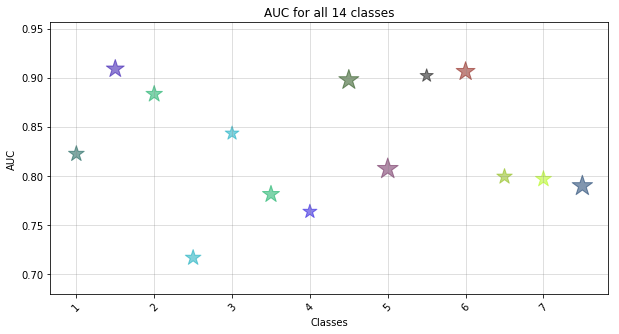

{'Effusion': 2, 'Pneumothorax': 7, 'Edema': 9, 'Cardiomegaly': 1, 'Pleural_Thickening': 12, 'Atelectasis': 0, 'Consolidation': 8, 'Emphysema': 10, 'Pneumonia': 6, 'Nodule': 5, 'Mass': 4, 'Infiltration': 3, 'Hernia': 13, 'Fibrosis': 11}


In [25]:
print("evaluating on training data: ")
evaluate(trainingDF)
SQLContext(sc).clearCache()

### Evaluate the model and plot AUC accuracy for Validation Data


evaluating on validation data: 
roc score for                Atelectasis  is:  0.789614683078      
roc score for               Cardiomegaly  is:  0.873129705242      
roc score for                   Effusion  is:  0.86535223927       
roc score for               Infiltration  is:  0.689784217336      
roc score for                       Mass  is:  0.807491318964      
roc score for                     Nodule  is:  0.729128038656      
roc score for                  Pneumonia  is:  0.731538559827      
roc score for               Pneumothorax  is:  0.870473697194      
roc score for              Consolidation  is:  0.794522984466      
roc score for                      Edema  is:  0.88673157811       
roc score for                  Emphysema  is:  0.887188623658      
roc score for                   Fibrosis  is:  0.76269875379       
roc score for         Pleural_Thickening  is:  0.768316659619      
roc score for                     Hernia  is:  0.759881110551      
('Finished eval

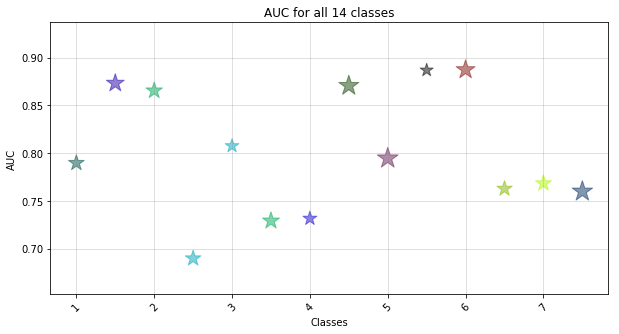

{'Effusion': 2, 'Pneumothorax': 7, 'Edema': 9, 'Cardiomegaly': 1, 'Pleural_Thickening': 12, 'Atelectasis': 0, 'Consolidation': 8, 'Emphysema': 10, 'Pneumonia': 6, 'Nodule': 5, 'Mass': 4, 'Infiltration': 3, 'Hernia': 13, 'Fibrosis': 11}


In [26]:
print("\nevaluating on validation data: ")
evaluate(validationDF)

### Loss function Graph 

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


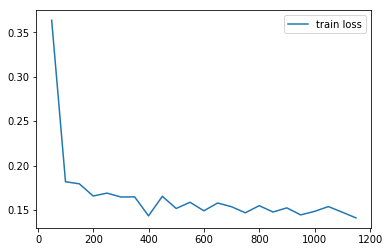

In [27]:
import matplotlib as plt
import numpy as np 

#pylab
%matplotlib notebook
%pylab inline 
#import matplotlib.pyplot as plt 
pylab.figure()

#retrieve train and validation summary object and read the loss data into ndarray's. 
loss = np.array(train_summary.read_scalar("Loss"))

plt.plot(loss[:,0],loss[:,1],label='train loss')
#plt.plot(val_loss[:,0],val_loss[:,1],label='val loss') #,color='green')
#plt.scatter(val_loss[:,0],val_loss[:,1],color='green')
plt.legend();

## Using Tensorboard 

We can also use Tensorboard to visualize the model during training in the form of graphs for Learning Rate, Loss Function, Throughput and so on.
Please use the below command to run the tensorboard for detailed visualization.

The port number --port 8081 and 8082 from the below command can be modified according to the ports available on your network.